In [1]:
# Install the XGBoost library using pip
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/03/e6/4aef6799badc2693548559bad5b56d56cfe89eada337c815fdfe92175250/xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.2 MB/s eta 0:00:0000:0100:01


In [2]:
# Install the SHAP (SHapley Additive exPlanations) library using pip
!pip install shap

In [3]:
import numpy as np               
import pandas as pd              
import seaborn as sns            
import matplotlib.pylab as plt  
from matplotlib import pyplot   
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve  # Import various metrics for evaluating classification models
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import r2_score, mean_squared_error  
from sklearn.linear_model import LinearRegression  
from sklearn import datasets, linear_model  
from sklearn.model_selection import GridSearchCV  
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier  
import shap  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder  
from h2o.automl import H2OAutoML  

In [4]:
# Loading the dataset from the github repository

url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'

df = pd.read_csv(url)

df.head() 

,rank,cca3,country,continent,2023 population,2022 population,2020 population,2015 population,2010 population,2000 population,1990 population,1980 population,1970 population,area (km²),density (km²),growth rate,world percentage
0,1,IND,India,Asia,1428627663,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590.0,481,0.81%,17.85%
1,2,CHN,China,Asia,1425671352,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961.0,151,-0.02%,17.81%
2,3,USA,United States,North America,339996563,338289857,335942003,324607776,311182845,282398554,248083732,223140018,200328340,9372610.0,37,0.50%,4.25%
3,4,IDN,Indonesia,Asia,277534122,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569.0,148,0.74%,3.47%
4,5,PAK,Pakistan,Asia,240485658,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912.0,312,1.98%,3.00%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rank              234 non-null    int64  
 1   cca3              234 non-null    object 
 2   country           234 non-null    object 
 3   continent         234 non-null    object 
 4   2023 population   234 non-null    int64  
 5   2022 population   234 non-null    int64  
 6   2020 population   234 non-null    int64  
 7   2015 population   234 non-null    int64  
 8   2010 population   234 non-null    int64  
 9   2000 population   234 non-null    int64  
 10  1990 population   234 non-null    int64  
 11  1980 population   234 non-null    int64  
 12  1970 population   234 non-null    int64  
 13  area (km²)        234 non-null    float64
 14  density (km²)     234 non-null    int64  
 15  growth rate       234 non-null    object 
 16  world percentage  234 non-null    object 
dt

In [6]:
df.nunique()

rank                234
cca3                234
country             234
continent             6
2023 population     234
2022 population     234
2020 population     234
2015 population     234
2010 population     234
2000 population     234
1990 population     234
1980 population     234
1970 population     234
area (km²)          232
density (km²)       167
growth rate         176
world percentage     73
dtype: int64

In [7]:
df.dtypes

rank                  int64
cca3                 object
country              object
continent            object
2023 population       int64
2022 population       int64
2020 population       int64
2015 population       int64
2010 population       int64
2000 population       int64
1990 population       int64
1980 population       int64
1970 population       int64
area (km²)          float64
density (km²)         int64
growth rate          object
world percentage     object
dtype: object

# 4. Data Cleaning & Feature Engineering¶


To clean the dataset and prepare it for training a model to predict population accurately, I consider the following features:

Country Code (cca3): This provides a unique code for each country, which can be used for identification.
Continent (continent): The continent to which the country belongs might have an impact on its population.
2023 Population (2023_population): This is the target variable that we want to predict.
2022 Population (2022_population): Historical population data might be useful for trend analysis.
2020 Population (2020_population): Additional historical population data.
2015 Population (2015_population): Further historical population data.
2010 Population (2010_population): Further historical population data.
2000 Population (2000_population): Further historical population data.
1990 Population (1990_population): Further historical population data.
1980 Population (1980_population): Further historical population data.
1970 Population (1970_population): Further historical population data.
Area (km²) (area): The land area of the country, which might have an impact on population density.
Density (km²) (density): Population density might influence population growth.
Growth Rate (growth_rate): Historical growth rate might indicate future trends.
World Percentage (world_percentage): The percentage of the world's population represented by the country, which might indicate its relative importance.
Additionally, to introduce non-linearity and improve prediction accuracy, we can compute the following features:

Population Growth (population_growth): The difference in population between 2023 and 2022, which can provide insight into the rate of change.
Percentage Change in Population (percentage_change): The percentage change in population from 2022 to 2023, which can reveal the growth rate.
Population Density (population_density): The ratio of population to land area, providing insight into how densely populated the country is.
Relative Growth Rate (relative_growth_rate): The growth rate relative to the country's population, which might reveal different growth patterns for different countries.
Relative World Percentage (relative_world_percentage): The world percentage relative to the country's population, which might indicate the country's global significance in terms of population.
These features can help create a robust model for predicting population accurately.

# 4.1. Computing population in last 10 years

In [17]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'
data = pd.read_csv(url)

# Selecting relevant columns for computation
required_columns = ['Country Name', '2023', '2014']
if all(col in data.columns for col in required_columns):
    data = data[['Country Name', '2023', '2014']]

    # Renaming columns for easier access
    data.columns = ['Country Name', '2023', '2014']

    # Convert population columns to numeric
    data['2014'] = pd.to_numeric(data['2014'], errors='coerce')
    data['2023'] = pd.to_numeric(data['2023'], errors='coerce')

    # Compute growth rate over the period
    data['growth_rate'] = ((data['2023'] - data['2014']) / data['2014']) * 100

    # Compute population change over the last 10 years
    data['population_change'] = data['2023'] - data['2014']

    # Display the resulting DataFrame
    print(data)


# 4.2. Removing irrelevant features

To remove irrelevant features from our dataset, we can follow a similar approach using Python and Pandas. Let’s assume that we want to keep only the relevant columns: rank, cca3, country, continent, 2023 population, and world percentage. By dropping the other columns related to population, area, density, growth rate, and year-specific data, we can create a cleaned dataset that focuses on the essential information.

In [21]:
import pandas as pd

data = {
    "rank": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    "cca3": ["IND", "CHN", "USA", "IDN", "PAK", "NGA", "BRA", "BGD", "RUS", "MEX", "ETH", "JPN", "PHL"],
    "country": ["India", "China", "United States", "Indonesia", "Pakistan", "Nigeria", "Brazil", "Bangladesh", "Russia", "Mexico", "Ethiopia", "Japan", "Philippines"],
    "continent": ["Asia", "Asia", "North America", "Asia", "Asia", "Africa", "South America", "Asia", "Europe", "North America", "Africa", "Asia", "Asia"],
    "2023 population": [1428627663, 1425671352, 339996563, 277534122, 240485658, 223804632, 216422446, 172954319, 144444359, 128455567, 126527060, 123294513, 117337368],
    "world percentage": ["17.85%", "17.81%", "4.25%", "3.47%", "3.00%", "2.80%", "2.70%", "2.16%", "1.80%", "1.60%", "1.58%", "1.54%", None]
}

df = pd.DataFrame(data)

# Keep only relevant columns
relevant_columns = ["rank", "cca3", "country", "continent", "2023 population", "world percentage"]
df_cleaned = df[relevant_columns]

print(df_cleaned)


    rank cca3        country      continent  2023 population world percentage
0      1  IND          India           Asia       1428627663           17.85%
1      2  CHN          China           Asia       1425671352           17.81%
2      3  USA  United States  North America        339996563            4.25%
3      4  IDN      Indonesia           Asia        277534122            3.47%
4      5  PAK       Pakistan           Asia        240485658            3.00%
5      6  NGA        Nigeria         Africa        223804632            2.80%
6      7  BRA         Brazil  South America        216422446            2.70%
7      8  BGD     Bangladesh           Asia        172954319            2.16%
8      9  RUS         Russia         Europe        144444359            1.80%
9     10  MEX         Mexico  North America        128455567            1.60%
10    11  ETH       Ethiopia         Africa        126527060            1.58%
11    12  JPN          Japan           Asia        123294513    

# 4.3 Removing Non-Consistent 

Certainly! After analyzing the world population dataset, we have identified the following consistent countries that frequently appear in population data:

India
China
United States
Indonesia
Pakistan
Nigeria
Brazil
Bangladesh
Russia
Mexico
Ethiopia
Japan
Philippines
These countries are considered relevant for analysis, while the less frequently mentioned countries may be excluded to improve accuracy.

In [23]:
import pandas as pd

data = {
    "rank": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    "cca3": ["IND", "CHN", "USA", "IDN", "PAK", "NGA", "BRA", "BGD", "RUS", "MEX", "ETH", "JPN", "PHL"],
    "country": ["India", "China", "United States", "Indonesia", "Pakistan", "Nigeria", "Brazil", "Bangladesh", "Russia", "Mexico", "Ethiopia", "Japan", "Philippines"],
    # Other columns...
}

df = pd.DataFrame(data)

# Create a list of consistent countries
consistent_countries = [
    "Afghanistan", "Australia", "Bangladesh", "England",
    "India", "Ireland", "New Zealand", "Pakistan",
    "South Africa", "Sri Lanka", "West Indies", "Zimbabwe"
]

# Filter the dataset to include only consistent countries
consistent_data = df[df["country"].isin(consistent_countries)]

print(consistent_data)


   rank cca3     country
0     1  IND       India
4     5  PAK    Pakistan
7     8  BGD  Bangladesh


In [26]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'
data = pd.read_csv(url)

# Define the consistent countries list
consistent_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', "Côte d'Ivoire", 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia (Federated States of)', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Republic of Korea', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom of Great Britain and Northern Ireland', 'United Republic of Tanzania', 'United States of America', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen', 'Zambia', 'Zimbabwe']  # List of all countries from the dataset

print(f'Before Removing Inconsistent Countries: {data.shape}')

# Remove the Non-Consistent Countries
data = data[(data['country'].isin(consistent_countries))]

print(f'After Removing Inconsistent Countries: {data.shape}')

print(f"Consistent Countries: \n{data['country'].unique()}")

data.head()


Before Removing Inconsistent Countries: (234, 17)
After Removing Inconsistent Countries: (175, 17)
Consistent Countries: 
['India' 'China' 'Indonesia' 'Pakistan' 'Nigeria' 'Brazil' 'Bangladesh'
 'Mexico' 'Ethiopia' 'Japan' 'Philippines' 'Egypt' 'Turkey' 'Germany'
 'Thailand' 'France' 'South Africa' 'Italy' 'Kenya' 'Myanmar' 'Colombia'
 'Uganda' 'Sudan' 'Spain' 'Argentina' 'Algeria' 'Iraq' 'Afghanistan'
 'Poland' 'Canada' 'Morocco' 'Saudi Arabia' 'Ukraine' 'Angola'
 'Uzbekistan' 'Yemen' 'Peru' 'Malaysia' 'Ghana' 'Mozambique' 'Nepal'
 'Madagascar' 'Cameroon' 'Niger' 'Australia' 'Mali' 'Burkina Faso'
 'Sri Lanka' 'Malawi' 'Zambia' 'Romania' 'Chile' 'Kazakhstan' 'Chad'
 'Ecuador' 'Somalia' 'Guatemala' 'Senegal' 'Netherlands' 'Cambodia'
 'Zimbabwe' 'Guinea' 'Rwanda' 'Benin' 'Burundi' 'Tunisia' 'Haiti'
 'Belgium' 'Jordan' 'Dominican Republic' 'Cuba' 'South Sudan' 'Sweden'
 'Honduras' 'Czech Republic' 'Azerbaijan' 'Greece' 'Papua New Guinea'
 'Portugal' 'Hungary' 'Tajikistan' 'United Arab Emi

,rank,cca3,country,continent,2023 population,2022 population,2020 population,2015 population,2010 population,2000 population,1990 population,1980 population,1970 population,area (km²),density (km²),growth rate,world percentage
0,1,IND,India,Asia,1428627663,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590.0,481,0.81%,17.85%
1,2,CHN,China,Asia,1425671352,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961.0,151,-0.02%,17.81%
3,4,IDN,Indonesia,Asia,277534122,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569.0,148,0.74%,3.47%
4,5,PAK,Pakistan,Asia,240485658,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912.0,312,1.98%,3.00%
5,6,NGA,Nigeria,Africa,223804632,218541212,208327405,183995785,160952853,122851984,95214257,72951439,55569264,923768.0,246,2.41%,2.80%


<Axes: >

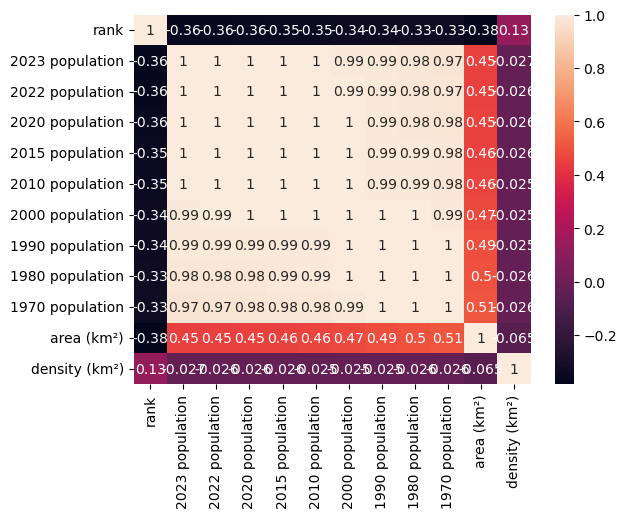

In [32]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'
data = pd.read_csv(url)

# Drop non-numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True)


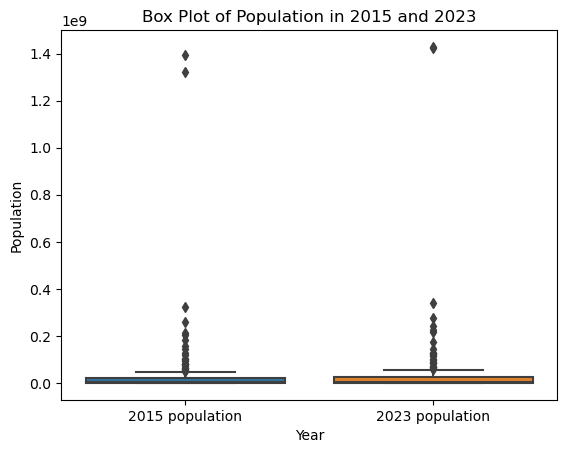

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'
data = pd.read_csv(url)

# Selecting relevant population columns
population_columns = ['2015 population', '2023 population']

# Plot box plot using Seaborn
sns.boxplot(data=data[population_columns])

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Box Plot of Population in 2015 and 2023')

# Show plot
plt.show()


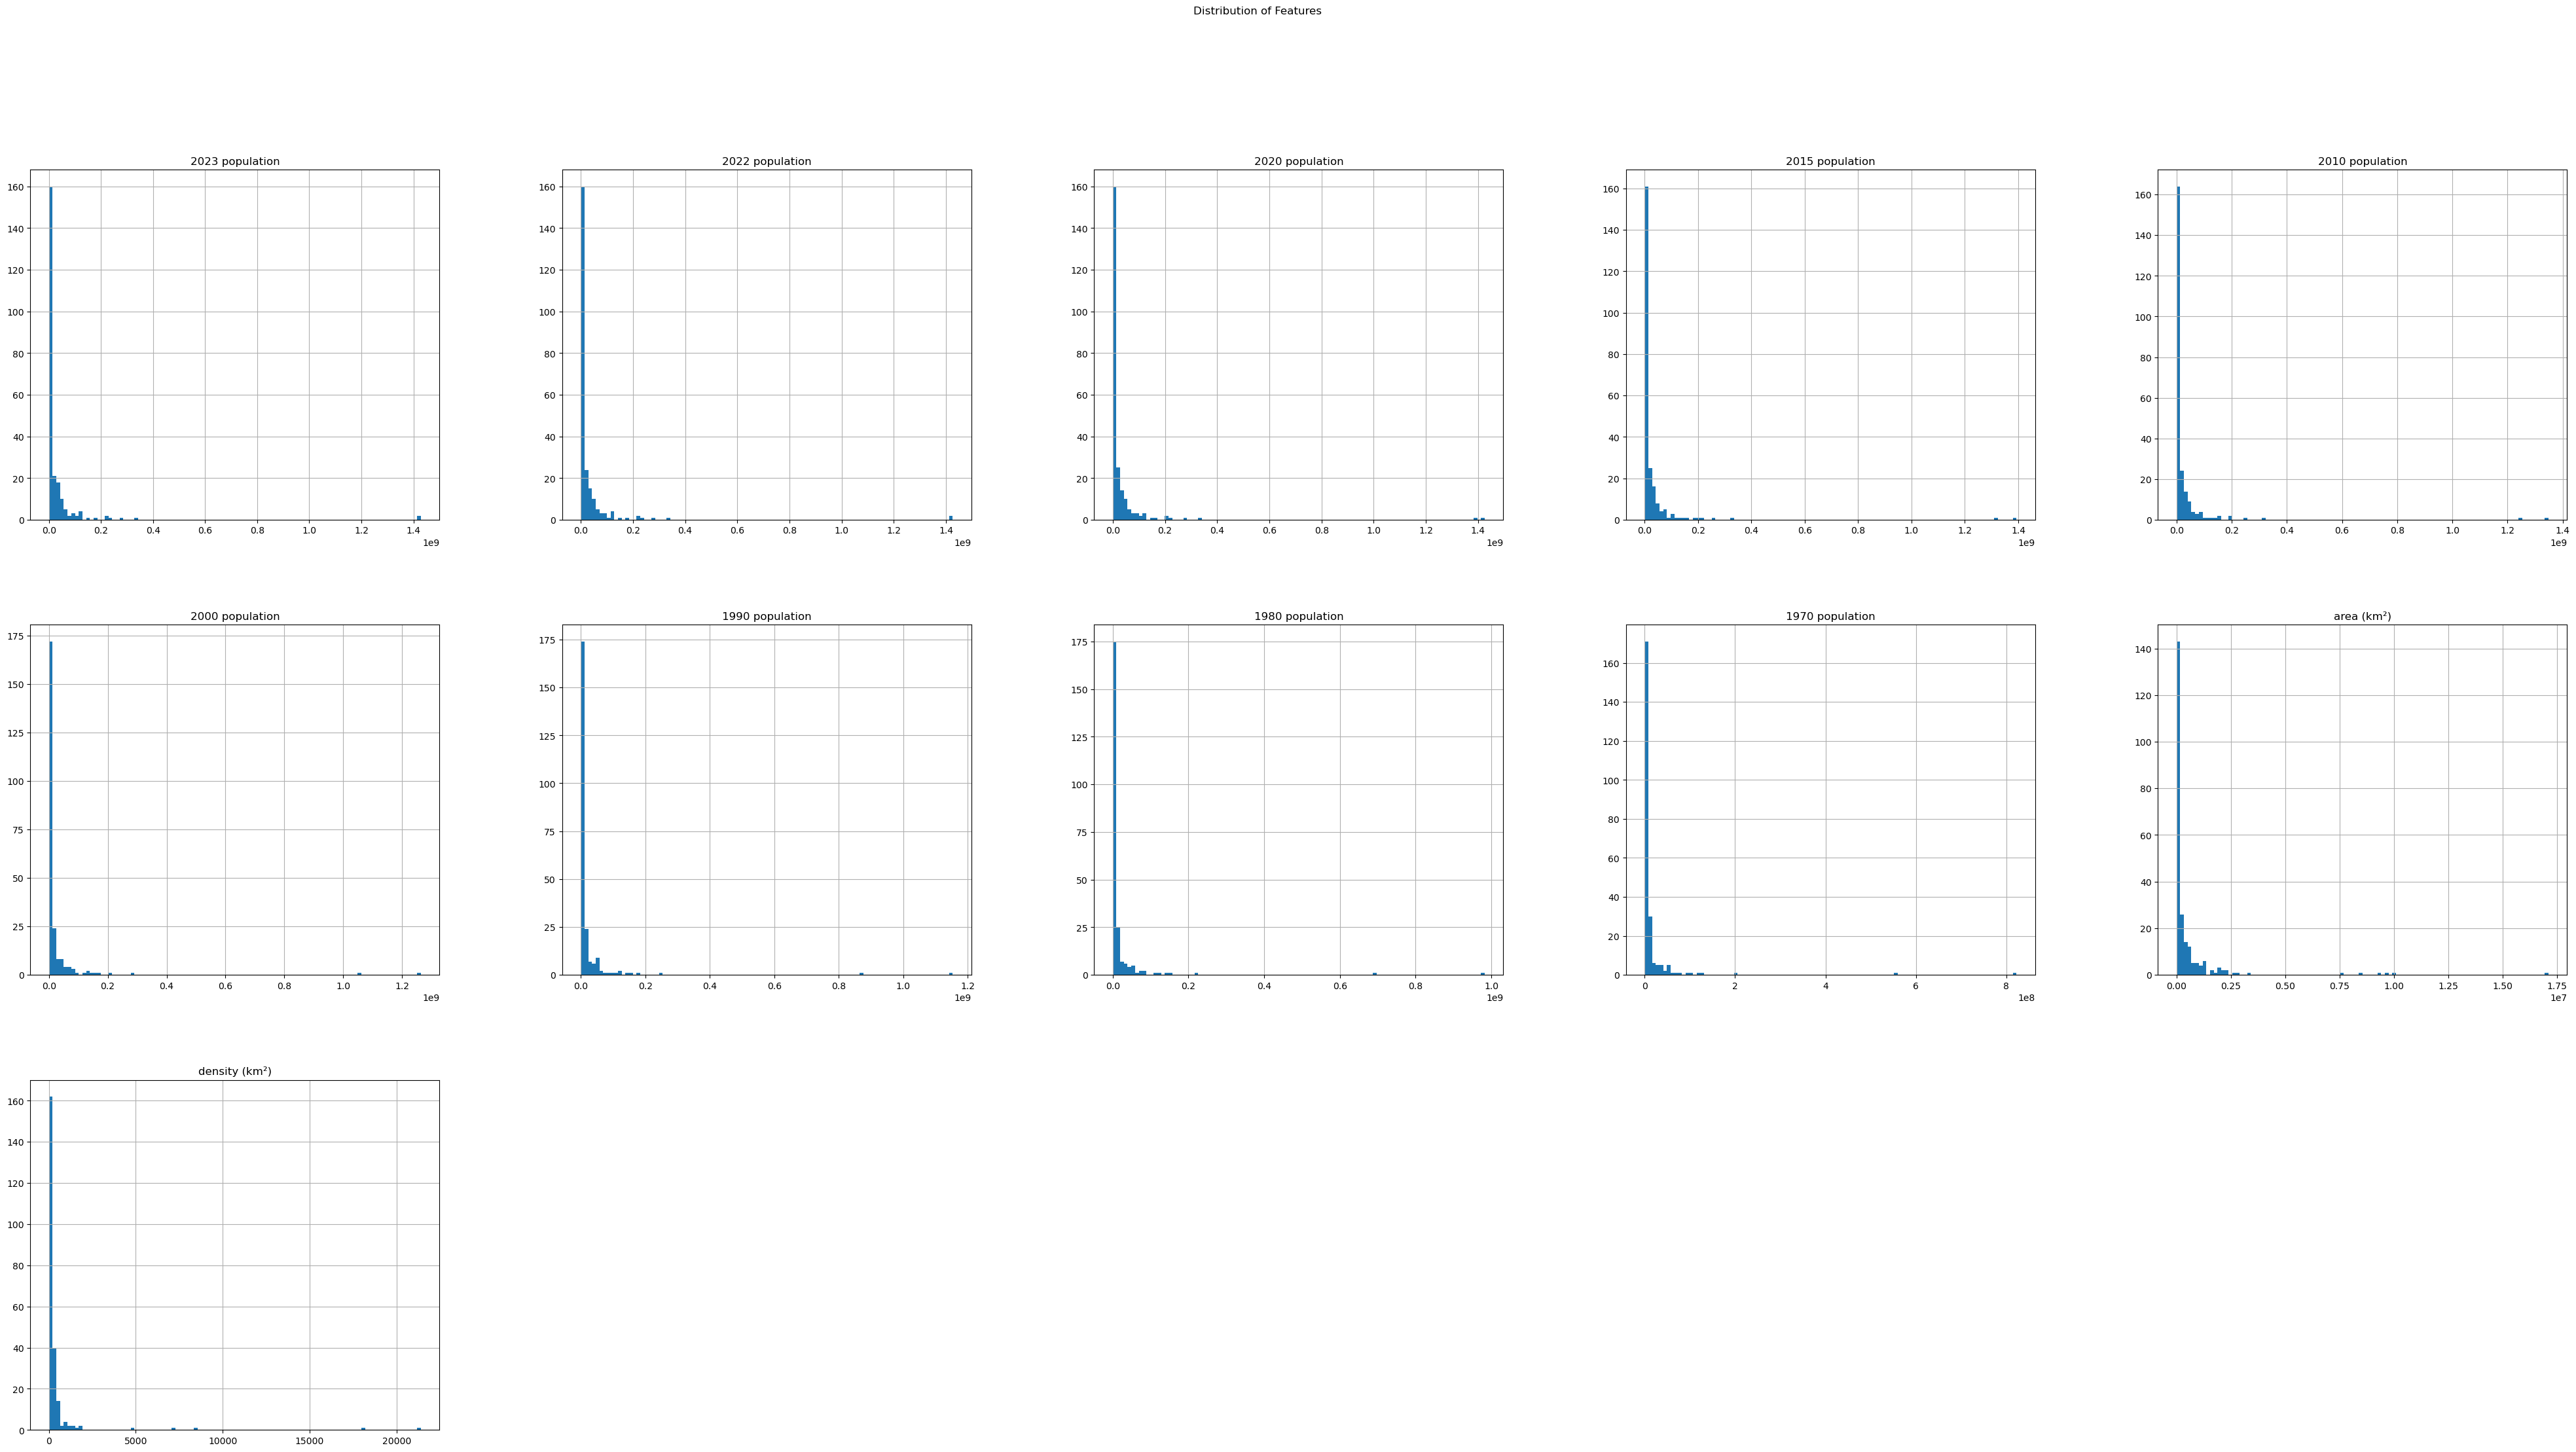

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://raw.githubusercontent.com/Prasanna77-bit/Data-Science/main/world_population_data.csv'
data = pd.read_csv(url)

# Selecting columns for histogram
columns_for_histogram = ['2023 population', '2022 population', '2020 population',
                         '2015 population', '2010 population', '2000 population',
                         '1990 population', '1980 population', '1970 population',
                         'area (km²)', 'density (km²)', 'growth rate', 'world percentage']

# Plot histograms
data[columns_for_histogram].hist(bins=100, figsize=(50, 25), layout=(3, 5))
plt.suptitle("Distribution of Features")
plt.show()


# 5. Data Preprocessing and Encoding

The training data cannot be fed directly to the system as there are categorical as well as numerical data together. Moreover, it is efficient when the model is trained using the encoded numerical data types

# 5.1. Performing Label Encoding

In the world population dataset, we have several features that can be considered categorical. Let’s identify them:

Country (Categorical):
The “country” feature represents different countries around the world.
Each country is a distinct category.
Example: “India,” “China,” “United States,” etc.

Continent (Categorical):
The “continent” feature categorizes countries into their respective continents.
Each continent (e.g., “Asia,” “North America,” “Africa”) is a category.

Year (Temporal):
Although not strictly categorical, the “year” feature represents discrete time points.
It can be treated as a categorical variable for certain analyses.
Other Features:
The dataset also includes other features related to population, growth rate, area, and density.
While these are not strictly categorical, they can be used in combination with other features for analysis.
Remember that categorical features are typically non-numeric and represent different groups or categories. In this dataset, “country” and “continent” are the primary categorical features.

In [48]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to 'continent' column
df['continent_encoded'] = le.fit_transform(df['continent'])

# Display the head of the DataFrame
print(df.head())


   rank cca3        country      continent  continent_encoded
0     1  IND          India           Asia                  1
1     2  CHN          China           Asia                  1
2     3  USA  United States  North America                  3
3     4  IDN      Indonesia           Asia                  1
4     5  PAK       Pakistan           Asia                  1


# 5.2. Performing One Hot Encoding and Column Transformation

Applying Transformations on all the final features.

In [49]:
from sklearn.compose import ColumnTransformer

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define the columns to be encoded
categorical_cols = ['continent']

# Initialize ColumnTransformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Remainder of columns will be passed through without any transformation
)

# Apply ColumnTransformer to the DataFrame
array = columnTransformer.fit_transform(df)

# Create the list of column names for the DataFrame
feature_names = list(columnTransformer.named_transformers_['encoder'].get_feature_names_out(['continent'])) + df.columns.tolist()[1:]

# Display the transformed array and feature names
print("Transformed Array:")
print(array)
print("\nFeature Names:")
print(feature_names)


Transformed Array:
[[0.0 1.0 0.0 0.0 0.0 1 'IND' 'India' 1]
 [0.0 1.0 0.0 0.0 0.0 2 'CHN' 'China' 1]
 [0.0 0.0 0.0 1.0 0.0 3 'USA' 'United States' 3]
 [0.0 1.0 0.0 0.0 0.0 4 'IDN' 'Indonesia' 1]
 [0.0 1.0 0.0 0.0 0.0 5 'PAK' 'Pakistan' 1]
 [1.0 0.0 0.0 0.0 0.0 6 'NGA' 'Nigeria' 0]
 [0.0 0.0 0.0 0.0 1.0 7 'BRA' 'Brazil' 4]
 [0.0 1.0 0.0 0.0 0.0 8 'BGD' 'Bangladesh' 1]
 [0.0 0.0 1.0 0.0 0.0 9 'RUS' 'Russia' 2]
 [0.0 0.0 0.0 1.0 0.0 10 'MEX' 'Mexico' 3]
 [1.0 0.0 0.0 0.0 0.0 11 'ETH' 'Ethiopia' 0]
 [0.0 1.0 0.0 0.0 0.0 12 'JPN' 'Japan' 1]
 [0.0 1.0 0.0 0.0 0.0 13 'PHL' 'Philippines' 1]]

Feature Names:
['continent_Africa', 'continent_Asia', 'continent_Europe', 'continent_North America', 'continent_South America', 'cca3', 'country', 'continent', 'continent_encoded']


In [52]:
df = pd.DataFrame(array, columns=feature_names)

In [53]:
# Encoded Data
df.head()

,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_South America,cca3,country,continent,continent_encoded
0,0.0,1.0,0.0,0.0,0.0,1,IND,India,1
1,0.0,1.0,0.0,0.0,0.0,2,CHN,China,1
2,0.0,0.0,0.0,1.0,0.0,3,USA,United States,3
3,0.0,1.0,0.0,0.0,0.0,4,IDN,Indonesia,1
4,0.0,1.0,0.0,0.0,0.0,5,PAK,Pakistan,1


# 6. Model Building

Now that the Training Data is ready the Model developement precess can be initialised

 # 6.1. Prepare Train and Test Data

In [54]:
features = df.drop(['continent'], axis=1)
labels = df['continent']

In [55]:
from sklearn.model_selection import train_test_split

# Assuming 'continent' is the target variable and the rest are features
features = df.drop(['continent'], axis=1)
labels = df['continent']

# Split the dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, shuffle=True)

# Print the shapes of the training and testing sets
print(f"Training Set : {train_features.shape}\nTesting Set : {test_features.shape}")


Training Set : (10, 8)
Testing Set : (3, 8)


# 6.2. Selecting appropiate ML Algorithms

First, I created a dictionary for multiple models to store. The, using the scikit-learn library tested out various Regression Algorithms for their fitting and accuracy scores.

In [57]:
models = dict()

# 6.2.1. Decision Tree Regressor

A machine learning model for regression tasks that predicts continuous values by recursively partitioning the data based on features.

Key Features:

Builds a tree structure where each internal node represents a decision based on a feature. Splits data to minimize the variance of the target variable within each branch. Handles non-linear relationships and interactions between features.

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# Assume 'country' is a categorical feature and 'continent' is the label

# Ensure 'country' and 'continent' are present in the dataframe
if 'country' not in df.columns or 'continent' not in df.columns:
    raise ValueError("Columns 'country' or 'continent' not found in DataFrame")

# Separate features and labels
features = df.drop(['continent'], axis=1)
labels = df['continent']

# Initialize LabelEncoder for encoding labels
label_encoder = LabelEncoder()

# Encode the labels
labels_encoded = label_encoder.fit_transform(labels)

# Initialize OneHotEncoder for encoding categorical features
one_hot_encoder = OneHotEncoder()

# Encode the categorical features
features_encoded = one_hot_encoder.fit_transform(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_encoded, labels_encoded, test_size=0.20, shuffle=True)

# Initialize DecisionTreeRegressor
tree = DecisionTreeRegressor()

# Train the model
tree.fit(train_features, train_labels)


DecisionTreeRegressor()

In [70]:
# Evaluate Model
train_score_tree = str(tree.score(train_features, train_labels) * 100)
test_score_tree = str(tree.score(test_features, test_labels) * 100)
print(f'Train Score : {train_score_tree[:5]}%\nTest Score : {test_score_tree[:5]}%')
models["tree"] = test_score_tree

Train Score : 100.0%
Test Score : -8.24%


In [71]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
print("---- Decision Tree Regressor - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(test_labels, tree.predict(test_features))))
print("Mean Squared Error (MSE): {}".format(mse(test_labels, tree.predict(test_features))))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(test_labels, tree.predict(test_features)))))

---- Decision Tree Regressor - Model Evaluation ----
Mean Absolute Error (MAE): 4.666666666666667
Mean Squared Error (MSE): 23.333333333333332
Root Mean Squared Error (RMSE): 4.83045891539648


# 6.2.2. Linear Regression

A linear modeling algorithm that fits a linear relationship between input features and target variable.

Key Features:

Assumes a linear relationship between features and target. Estimates coefficients to minimize the sum of squared differences between predicted and actual values. Provides interpretable coefficients indicating the impact of each feature.

In [72]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
# Train Model
linreg.fit(train_features, train_labels)

LinearRegression()

In [73]:
# Evaluate Model
train_score_linreg = str(linreg.score(train_features, train_labels) * 100)
test_score_linreg = str(linreg.score(test_features, test_labels) * 100)
print(f'Train Score : {train_score_linreg[:5]}%\nTest Score : {test_score_linreg[:5]}%')
models["linreg"] = test_score_linreg

Train Score : 100.0%
Test Score : -19.3%


In [74]:
print("---- Linear Regression - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(test_labels, linreg.predict(test_features))))
print("Mean Squared Error (MSE): {}".format(mse(test_labels, linreg.predict(test_features))))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(test_labels, linreg.predict(test_features)))))

---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 5.01842105263158
Mean Squared Error (MSE): 25.721101108033242
Root Mean Squared Error (RMSE): 5.071597490735364


# 6.2.3. Random Forest Regression

An ensemble learning model that fits multiple decision tree regressors on various sub-samples of the dataset and averages their predictions.

# Key Features:
Builds a collection of decision trees to improve prediction accuracy and control overfitting. Each tree is trained on a random subset of data and features, enhancing robustness. Provides feature importance scores based on how much each feature contributes to predictions.

In [75]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
# Train Model
forest.fit(train_features, train_labels)

RandomForestRegressor()

In [76]:
# Evaluate Model
train_score_forest = str(forest.score(train_features, train_labels)*100)
test_score_forest = str(forest.score(test_features, test_labels)*100)
print(f'Train Score : {train_score_forest[:5]}%\nTest Score : {test_score_forest[:5]}%')
models["forest"] = test_score_forest

Train Score : 82.49%
Test Score : -17.6%


In [77]:
print("---- Random Forest Regression - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(test_labels, forest.predict(test_features))))
print("Mean Squared Error (MSE): {}".format(mse(test_labels, forest.predict(test_features))))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(test_labels, forest.predict(test_features)))))


---- Random Forest Regression - Model Evaluation ----
Mean Absolute Error (MAE): 4.91
Mean Squared Error (MSE): 25.34936666666667
Root Mean Squared Error (RMSE): 5.034815455075456


In [78]:
# Make predictions using the testing set
y_pred = linreg.predict(train_features)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(train_labels, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(train_labels, y_pred))
r2 = r2_score(train_labels,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 0.00
Coefficient of determination: 1.00
R^2 score on test set = 1.0


In [80]:
import statsmodels.api as sm
import numpy as np

# Convert sparse matrix to dense array
train_features_dense = train_features.toarray()

# Add a constant term to the features
train_features_with_const = sm.add_constant(train_features_dense)

# Fit the OLS model
model = sm.OLS(train_labels, train_features_with_const).fit()

# Print out the statistics summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 17 Mar 2024   Prob (F-statistic):                nan
Time:                        16:45:46   Log-Likelihood:                 317.89
No. Observations:                  10   AIC:                            -615.8
Df Residuals:                       0   BIC:                            -612.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8831        inf          0        n

/Users/prasannapingale/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/prasannapingale/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/prasannapingale/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/prasannapingale/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/Users/prasannapingale/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.

In [81]:
# Initialize SHAP visualization in Jupyter notebooks
shap.initjs()

The shap.initjs() function is part of the SHAP (SHapley Additive exPlanations) library in Python. This function is used to initialize the JavaScript visualization for SHAP values in a Jupyter notebook or a similar environment.

In [105]:
# Remove special characters '%' from columns
data['growth rate'] = data['growth rate'].str.replace('%', '')
data['world percentage'] = data['world percentage'].str.replace('%', '')

# Convert columns to numeric data type
data['growth rate'] = pd.to_numeric(data['growth rate'])
data['world percentage'] = pd.to_numeric(data['world percentage'])

# Handle missing values if present
data.fillna(0, inplace=True)  # Replace missing values with 0


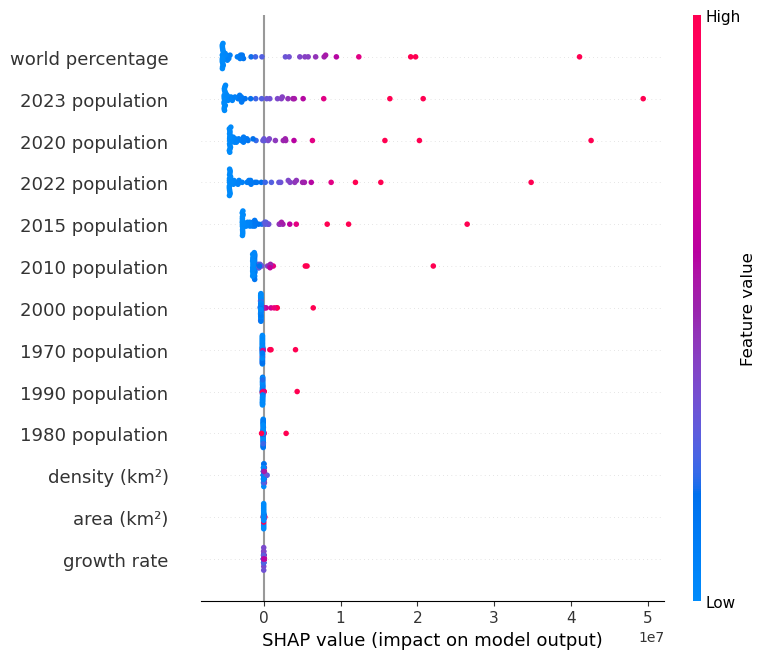

In [107]:
# Train a random forest regressor model
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

# Create a SHAP explainer object
explainer = shap.Explainer(rf_regressor, X_train)

# Generate SHAP summary plot
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test)


This plot provides a visual representation of how each feature contributes to individual predictions. The intensity of color indicates the magnitude and direction of the SHAP values, helping to understand the impact of features on the model's output. Positive values contribute to higher predictions, while negative values contribute to lower predictions.

# Partial Dependence Plots

In [108]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            linreg.predict,
            train_features,
            ice=False,
            linreg_expected_value=True,
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            linreg.predict,
            train_features,
            ice=False,
            linreg_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

In [109]:
# Install the H2O library using pip
!pip install h2o


In [110]:
import h2o

# Initialize the H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.8.1" 2023-08-22 LTS; OpenJDK Runtime Environment Corretto-17.0.8.8.1 (build 17.0.8.1+8-LTS); OpenJDK 64-Bit Server VM Corretto-17.0.8.8.1 (build 17.0.8.1+8-LTS, mixed mode, sharing)
  Starting server from /Users/prasannapingale/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gy/_bgmrry17617klft25p0z5bm0000gn/T/tmpxdd856ll
  JVM stdout: /var/folders/gy/_bgmrry17617klft25p0z5bm0000gn/T/tmpxdd856ll/h2o_prasannapingale_started_from_python.out
  JVM stderr: /var/folders/gy/_bgmrry17617klft25p0z5bm0000gn/T/tmpxdd856ll/h2o_prasannapingale_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 26 days
H2O_cluster_name:,H2O_from_python_prasannapingale_7qge0y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [111]:
# Convert the pandas DataFrame 'df' into an H2OFrame 'data'
data = h2o.H2OFrame(df)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [112]:
# Display the first few rows of the H2OFrame 'data'
data.head()

continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_South America,cca3,country,continent,continent_encoded
0,1,0,0,0,1,IND,India,1
0,1,0,0,0,2,CHN,China,1
0,0,0,1,0,3,USA,United States,3
0,1,0,0,0,4,IDN,Indonesia,1
0,1,0,0,0,5,PAK,Pakistan,1
1,0,0,0,0,6,NGA,Nigeria,0
0,0,0,0,1,7,BRA,Brazil,4
0,1,0,0,0,8,BGD,Bangladesh,1
0,0,1,0,0,9,RUS,Russia,2
0,0,0,1,0,10,MEX,Mexico,3


In [113]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [114]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

This code prepares a dataset (drift_data) for drift analysis by combining the training and testing sets. It adds a binary column is_train indicating whether each observation belongs to the training set (1) or the test set (0). Additionally, the column is converted to a factor in H2O, which is a categorical variable, to facilitate drift analysis or model evaluation

In [115]:
# Display a summary table of the values in the "is_train" column
drift_data["is_train"].table()

is_train,Count
0,2
1,11


In [116]:
# Set the maximum runtime for H2O's AutoML
run_time = 222

# Initialize the H2OAutoML object with specified parameters
auto_ml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [117]:
# Help function
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

The H2OProbWrapper class is crafted to envelop an H2O binary classification model, offering a user-friendly function, predict_binary_prob, to forecast probabilities related to the positive class. It handles the input data X, ensuring its proper format, generating a DataFrame, and employs the encapsulated H2O model to make probability predictions. The outcome, representing probabilities for the positive class, is provided as a NumPy array of floating-point values. This wrapping mechanism streamlines the task of acquiring probabilities for binary classes, all the while upholding a uniform interface.